In [1]:
# Southwest Atlantic analysis
# Plots surface vel, EKE and a vertical section of meridional vel for 3 diff resolutions of ACCESS-OM2
# 06 Mar 2019
# Modified by AK 4 Apr 2019

#%matplotlib inline
%pylab inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import numpy as np
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import scipy as sp
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import netCDF4 as nc
import matplotlib.gridspec as gridspec
from scipy.io import loadmat

from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display

# for georefferenced data
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm # for colormap

from dask.distributed import Client, progress

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/Southwest_Atlantic"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# List of experiments to compare
EXP = [exptdata.exptdict[e]['expt'] for e in exptdata.exptdict.keys()]
ncfile = ['ocean.nc','ocean.nc','ocean.nc']
n_files = [exptdata.exptdict[e]['n_files'] for e in exptdata.exptdict.keys()]

In [3]:
reg = [-60,-30,-60,-30]; # Argentine Basin, [S N W E]
DEPTH = 0;

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [4]:
# In one terminal run: dask-scheduler (make sure cosima modules are loaded)
# In another terminal run: 
# dask-worker tcp://10.6.43.39:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/w97/gsp599
# where XX will be provided in the first terminal, and YYYZZZ is your NCI login 
# (for more information on this see figures/dynamic_topo/PacificSSHTrends.ipynb)

client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.124.36:8786' processes=1 threads=28, memory=125.20 GiB>

In [6]:
for ekey in exptdata.exptdict.keys():
    e = exptdata.exptdict[ekey]

    ## Load zonal velocity from experiment
    offset = e['offset']
    cat_subset = catalog[e['expt']]
    var_search = cat_subset.search(variable='u', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['u']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    u = darray.sel(time=slice(tstart,tend))\
        .sel(st_ocean=DEPTH,method='nearest')\
        .sel(yu_ocean=slice(reg[0],reg[1]))\
        .sel(xu_ocean=slice(reg[2],reg[3]))\
        .load()
    um = u.mean('time')

    ## Load meridional velocity from expt
    offset = e['offset']
    cat_subset = catalog[e['expt']]
    var_search = cat_subset.search(variable='v', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['v']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    v = darray.sel(time=slice(tstart,tend))\
        .sel(st_ocean=DEPTH,method='nearest')\
        .sel(yu_ocean=slice(reg[0],reg[1]))\
        .sel(xu_ocean=slice(reg[2],reg[3]))\
        .load()
    vm = v.mean('time')
    
    locals()['vel_mean_'+ekey] = np.sqrt(um**2+vm**2)

#     ## Calculate EKE
## Not used: EKE is incorrect as it only includes variation on timescales longer than the file averaging (annual at 1 deg and 0.25 deg, monthly at 0.1deg)
#     u_prime = (u - um)*100
#     v_prime = (v - vm)*100
#     EKE = (u_prime**2 + v_prime**2)/2
#     EKE_mean_1deg = EKE.mean(axis=0)

    # SLA std
    #sea_level = cc.get_nc_variable(exp,'ocean_month.nc','sea_level',n=n_files[ii]).\
    #    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
    #sea_levelsq = cc.get_nc_variable(exp,'ocean_month.nc','sea_levelsq',n=n_files[ii]).\
    #    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
    #sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
    #sla_rms_1deg.load()



In [7]:
# 1 deg

# TODO: sel(time=slice(tstart,tend))

ii = 0;
exp = EXP[ii] 
print(exp)
offset = exptdata.exptdict['1deg']['offset']

## Load zonal velocity from experiment
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='u', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['u']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
u = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
um = u.mean('time')

## Load meridional velocity from expt
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='v', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['v']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
v = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
vm = v.mean('time')
vel_mean_1deg = np.sqrt(um**2+vm**2)

## Calculates EKE
## EKE is incorrect as it only includes variation on timescales longer than the file averaging (annual at 1 deg and 0.25 deg, monthly at 0.1deg)
u_prime = (u - um)*100
v_prime = (v - vm)*100
EKE = (u_prime**2 + v_prime**2)/2
EKE_mean_1deg = EKE.mean(axis=0)

# SLA std
#sea_level = cc.get_nc_variable(exp,'ocean_month.nc','sea_level',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sea_levelsq = cc.get_nc_variable(exp,'ocean_month.nc','sea_levelsq',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
#sla_rms_1deg.load()


1deg_jra55v13_iaf_spinup1_B1


In [8]:
# for testing
vel_mean_025deg = vel_mean_1deg
vel_mean_01deg = vel_mean_1deg

# EKE_mean_025deg = EKE_mean_1deg
# EKE_mean_01deg = EKE_mean_1deg

In [9]:
# 025 deg
ii = 1;
exp = EXP[ii] 
print(exp)

## Load zonal velocity from experiment
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='u', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['u']
u = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(time=slice(tstart,tend)).sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
um = u.mean('time')

## Load meridional velocity from expt
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='v', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['v']
v = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(time=slice(tstart,tend)).sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
vm = v.mean('time')
vel_mean_025deg = np.sqrt(um**2+vm**2)

## Calculates EKE
## EKE is incorrect as it only includes variation on timescales longer than the file averaging (annual at 1 deg and 0.25 deg, monthly at 0.1deg)
u_prime = (u - um)*100
v_prime = (v - vm)*100
EKE = (u_prime**2 + v_prime**2)/2
EKE_mean_025deg = EKE.mean(axis=0)

# SLA std
#sea_level = cc.get_nc_variable(exp,'ocean_month.nc','sea_level',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sea_levelsq = cc.get_nc_variable(exp,'ocean_month.nc','sea_levelsq',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sla_rms_025deg = (sea_levelsq - sea_level**(2.0))**(0.5)
#sla_rms_025deg.load()

025deg_jra55v13_iaf_gmredi6


In [10]:
# 01 deg
ii = 2;
exp = EXP[ii] 
print(exp)
#Surf vel
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='u')
darray = var_search.to_dask()
darray = darray['u']
u = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(time=slice(tstart,tend)).sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
um = u.mean('time')
cat_subset = catalog[exp]
var_search = cat_subset.search(variable='v')
darray = var_search.to_dask()
darray = darray['v']
v = darray.sel(st_ocean=DEPTH,method='nearest').\
    sel(time=slice(tstart,tend)).sel(yu_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3])).load() 
vm = v.mean('time')
vel_mean_01deg = np.sqrt(um**2+vm**2)

## Calculates EKE
## EKE is incorrect as it only includes variation on timescales longer than the file averaging (annual at 1 deg and 0.25 deg, monthly at 0.1deg)
u_prime = (u - um)*100
v_prime = (v - vm)*100
EKE = (u_prime**2 + v_prime**2)/2
EKE_mean_01deg = EKE.mean(axis=0)

# SLA std
#sea_level = cc.get_nc_variable(exp,'ocean_month.nc','sea_level',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sea_levelsq = cc.get_nc_variable(exp,'ocean_month.nc','sea_levelsq',n=n_files[ii]).\
#    sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3])).mean('time') 
#sla_rms_01deg = (sea_levelsq - sea_level**(2.0))**(0.5)
#sla_rms_01deg.load()

01deg_jra55v13_iaf


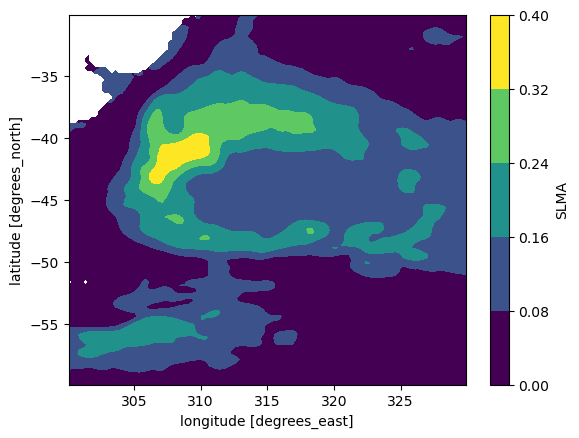

In [11]:
# OBS - SLMA
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
sea_level_obs = xr.open_dataset(aviso_file).SLMA.mean('TAXM')
sea_level_obs_bc = sea_level_obs.sel(LAT=slice(reg[0],reg[1])).sel(LON=slice(reg[2]+360,reg[3]+360)) 
sea_level_obs_bc.plot.contourf()

# OBS: drifter velocities (Laurindo et al., 2017)
obs_file = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/drifter_annualmeans.nc').\
           rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
obs_v = obs_file['V']
obs_vel = np.sqrt(obs_u**2+obs_v**2)
obs_vel = obs_vel.set_xindex(['longitude'])
obs_vel = obs_vel.set_xindex(['latitude'])
obs_vel_bc = obs_vel.sel(latitude=slice(reg[0],reg[1])).sel(longitude=slice(reg[2],reg[3])) 

# EKE
# EKEobs = xr.open_dataset('/g/data/w97/gsp599/cosima-recipes-master/Tutorials/meanEKE.nc')
EKEobs = xr.open_dataset('meanEKE.nc')

#plt.contourf(EKEobs.X,EKEobs.Y,EKEobs.meanEKE)



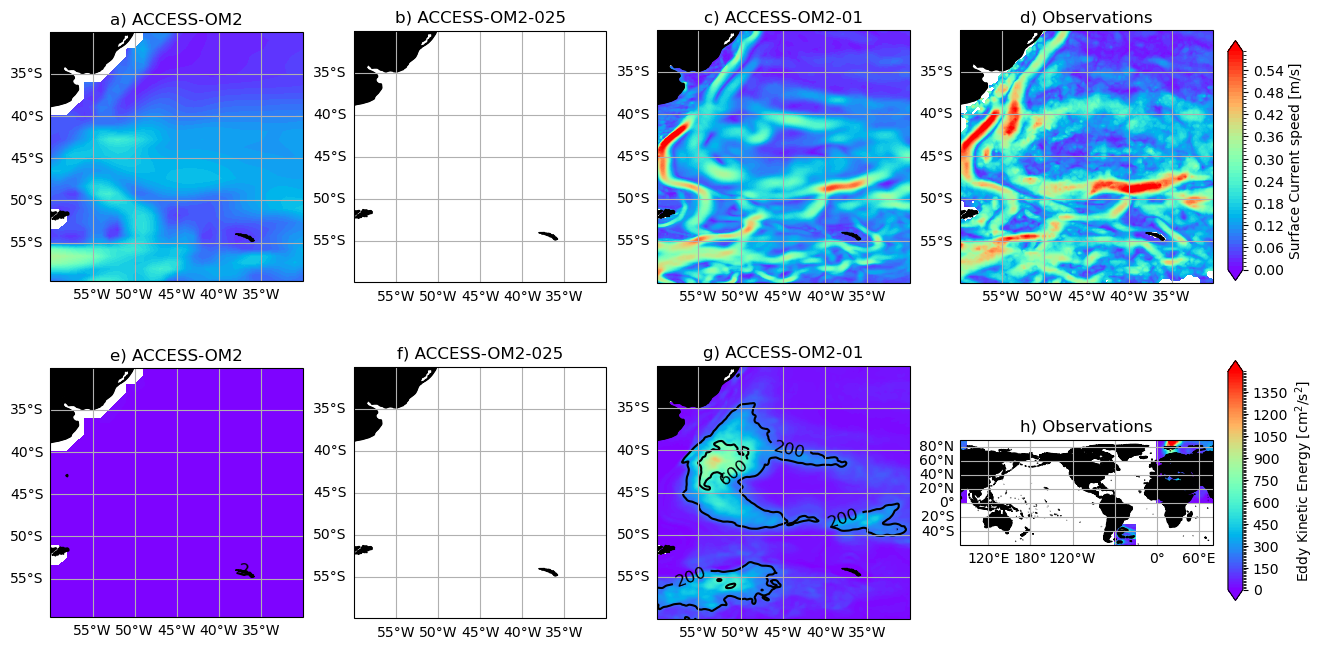

In [12]:
# Plotting surface surrent and EKE

# Not used: EKE is incorrect as it only includes variation on timescales longer than the file averaging (annual at 1 deg and 0.25 deg, monthly at 0.1deg)

ftszSLA = 12
ftszTITLE = 12

plt.figure(figsize=(15,8))
cmp = plt.get_cmap('rainbow')
clev1 = np.arange(0,0.6,0.01)
#clev2 = np.arange(0,0.3,0.01)
clev2 = np.arange(0,1500,10)

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='black',linewidth=0.5)

sub1 = [1,2,3,4]
sub2 = [5,6,7,8]
flvel = ['vel_mean_1deg','vel_mean_025deg','vel_mean_01deg','obs_vel_bc']
#flsla = ['sla_rms_1deg','sla_rms_025deg','sla_rms_01deg','sea_level_obs_bc']
flsla = ['EKE_mean_1deg','EKE_mean_025deg','EKE_mean_01deg','EKEobs.meanEKE']
tit1 = ['a) ACCESS-OM2','b) ACCESS-OM2-025','c) ACCESS-OM2-01','d) Observations']
tit2 = ['e) ACCESS-OM2','f) ACCESS-OM2-025','g) ACCESS-OM2-01','h) Observations']
LEVELS = ([1,2],[30,100],[200,600],[600,1200])

for ii in range(3): #[0,1,2]:
    # Surf Curr
    ax = plt.subplot(2,4,sub1[ii],projection=ccrs.PlateCarree(central_longitude=-100))
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    gl.xlabels_bottom = True
    gl.ylabels_left = True

    p2 = eval(flvel[ii]).plot.contourf(cmap=cmp,levels=clev1,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    plt.title(tit1[ii])
    # SLA std
    ax = plt.subplot(2,4,sub2[ii],projection=ccrs.PlateCarree(central_longitude=-100))
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    gl.xlabels_bottom = True
    gl.ylabels_left = True
    p2 = eval(flsla[ii]).plot.contourf(cmap=cmp,levels=clev2,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p3 = eval(flsla[ii]).plot.contour(colors='k',levels=LEVELS[ii],add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
    plt.clabel(p3, inline=True, fmt='%1.0f', fontsize=ftszSLA, colors='k')
    plt.title(tit2[ii])

# Surf Curr from drifters
ax = plt.subplot(2,4,4,projection=ccrs.PlateCarree(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
gl.xlabels_bottom = True
gl.ylabels_left = True
p1 = swapaxes(obs_vel_bc,0,1).plot.contourf(cmap=cmp,levels=clev1,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title(tit1[3])

ax1 = plt.axes([0.91,0.55,0.01,0.3])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical',pad=.05)
cb.ax.set_ylabel('Surface Current speed [m/s]')

# AVISO EKE
ax = plt.subplot(2,4,8,projection=ccrs.PlateCarree(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
gl.xlabels_bottom = True
gl.ylabels_left = True
p2 = plt.contourf(EKEobs.X,EKEobs.Y,EKEobs.meanEKE,cmap=cmp,levels=clev2,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p2 = eval(flsla[3]).plot.contourf(cmap=cmp,levels=clev2,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p3 = plt.contour(EKEobs.X,EKEobs.Y,EKEobs.meanEKE,colors='k',levels=[600,1200],add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
plt.clabel(p3, inline=True, fmt='%1.0f', fontsize=ftszSLA, colors='k')
plt.title(tit2[3])

ax2 = plt.axes([0.91,0.15,0.01,0.3])
cb = plt.colorbar(p2,cax=ax2,orientation='vertical',pad=.05)
#cb.ax.set_ylabel('Sea Level std [m]')
cb.ax.set_ylabel('Eddy Kinetic Energy [cm$^{2}$/s$^{2}$]')

# figdir = '/g/data/w97/gsp599/figures/'
figdir = ''
figname = 'SW_Atlantic_cosima_EKE'
# plt.savefig(os.path.join(figdir, figname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving

<a list of 5 text.Text objects>

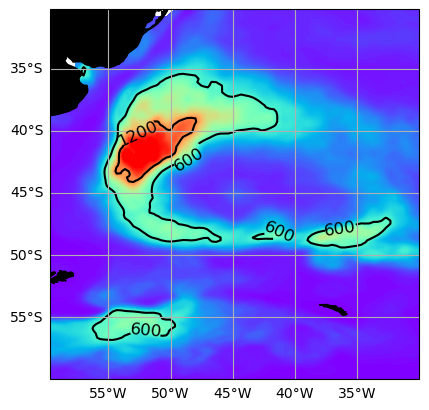

In [13]:
LEVELS = ([1,2],[30,100],[200,600],[600,1200])


# AVISO EKE
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
gl.xlabels_bottom = True
gl.ylabels_left = True
p2 = plt.contourf(EKEobs.X,EKEobs.Y,EKEobs.meanEKE,cmap=cmp,levels=clev2,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p3 = plt.contour(EKEobs.X,EKEobs.Y,EKEobs.meanEKE,colors='k',levels=[600,1200],add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
plt.clabel(p3, inline=True, fmt='%1.0f', fontsize=ftszSLA, colors='k')
   


## The following is from BarotropicStreamfunction.ipynb

In [25]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='tx_trans_int_z')
    darray = var_search.to_dask()
    darray = darray['tx_trans_int_z']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    cntrl_tx_trans = darray.sel(time=slice(tstart,tend))\
                                        .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

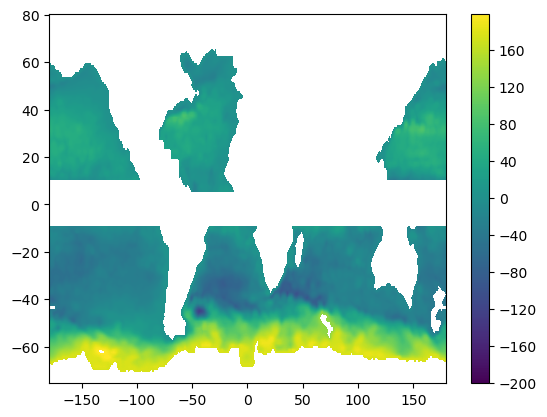

In [15]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200)) #,cmap = cm.cm.balance)
plt.colorbar()

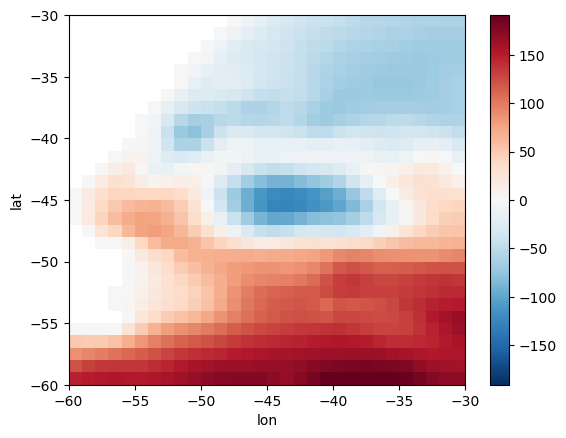

In [16]:
psida = xr.DataArray(psi, coords=[('lat', lat), ('lon', lon)])\
    .sel(lat=slice(reg[0],reg[1])).sel(lon=slice(reg[2],reg[3]))
psida.plot()

In [17]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')

In [19]:
# %%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
# sla_rms_1deg.load()

In [20]:
# %%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_025deg = (sea_levelsq - sea_level**(2.0))**(0.5)
# sla_rms_025deg.load()

In [22]:
# %%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='eta_t', frequency='1 daily')
darray = var_search.to_dask()
darray = darray['eta_t']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_01deg = (sea_levelsq - sea_level**(2.0))**(0.5)
# sla_rms_01deg.load()

In [23]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')
SLMA = SLMA.assign_coords(LON=SLMA.LON-360)  # shift to match MOM coords (at least in this region)

In [26]:
gyre_psi_1deg = get_gyre_psi('1deg')
gyre_psi_025deg = get_gyre_psi('025deg')
gyre_psi_01deg = get_gyre_psi('01deg')

In [27]:
## All data is now loaded - make a dictionary for plotting
gyre_psi_dict = {'1deg': gyre_psi_1deg, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
sla_rms_dict = {'1deg': sla_rms_1deg, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}
# # FOR TESTING - FIX THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# gyre_psi_dict = {'1deg': gyre_psi_1deg, '025deg': gyre_psi_1deg, '01deg': gyre_psi_1deg}
# sla_rms_dict = {'1deg': sla_rms_1deg, '025deg': sla_rms_1deg, '01deg': sla_rms_1deg}
# # gyre_psi_dict = {'1deg': gyre_psi_1deg} #, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
# # sla_rms_dict = {'1deg': sla_rms_1deg} #, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}

Text(0, 0.5, 'Sea Level Standard Deviation (m)')

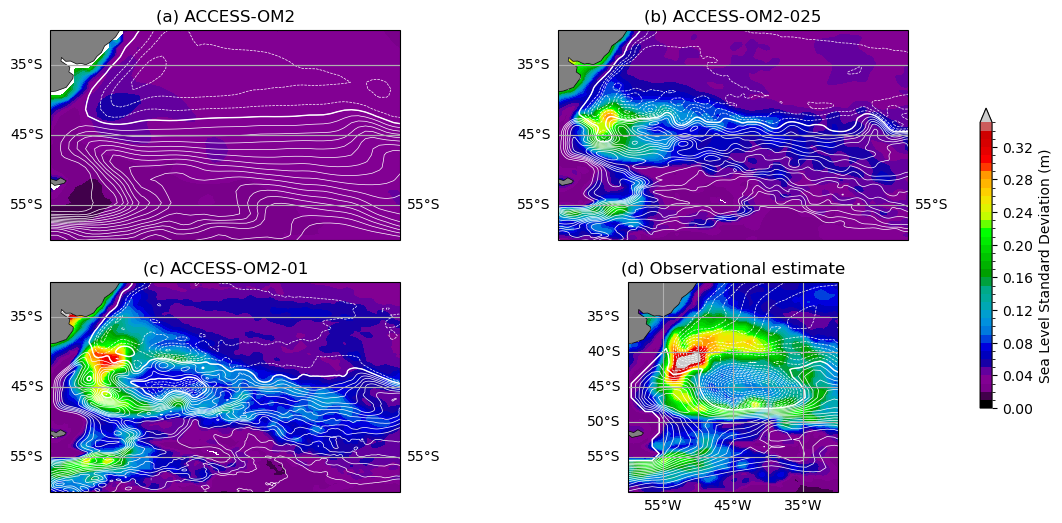

In [28]:
# Malvinas Region - TODO: fix!
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-150,150.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-60, -10, -60, -30], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160, -140],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-60, -30, -60, -30], crs=ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=range(-60,-29,5),ylocs=range(-60,-29,5))
gl.xlabels_top = False
# gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
# gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
# savefigure('malvinas_barotropic_streamfunctions')

## The above is from BarotropicStreamfunction.ipynb

1deg
025deg
01deg


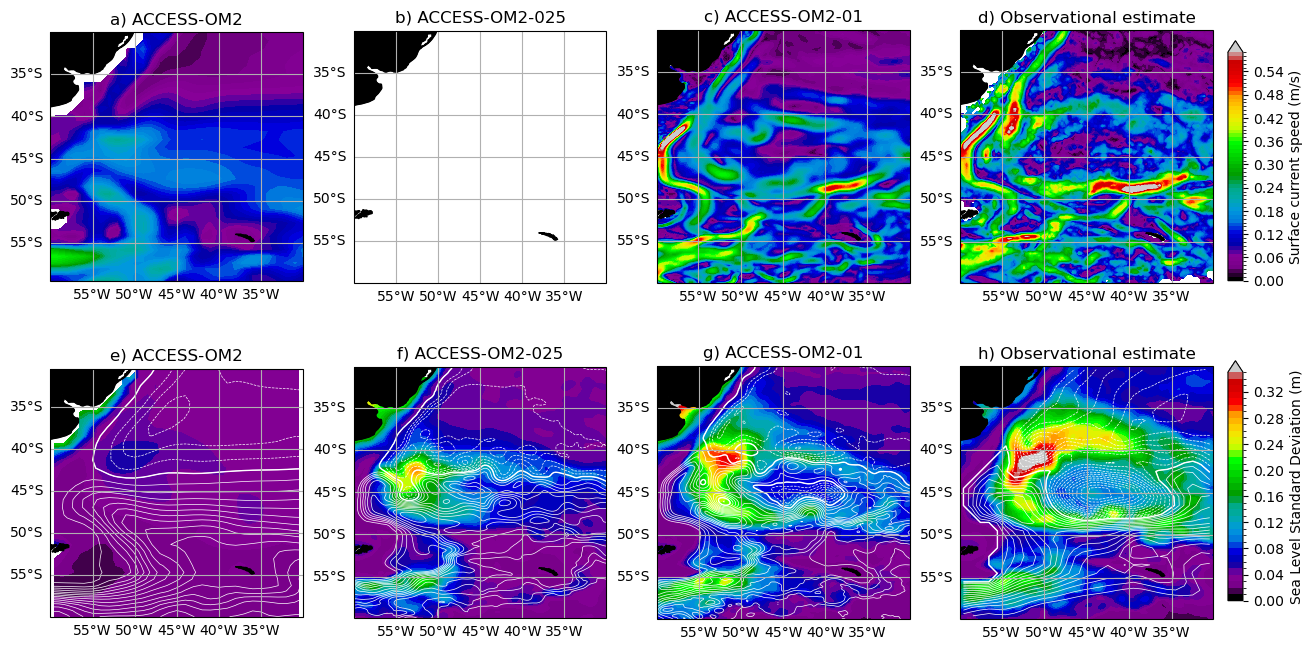

In [29]:
# Plotting with SLA variance instead of EKE
ftszSLA = 12
ftszTITLE = 12

plt.figure(figsize=(15,8))
cmp = plt.get_cmap('nipy_spectral') #('rainbow')
cmp2 = plt.get_cmap('nipy_spectral')
clev1 = np.arange(0,0.6,0.01)
#clev2 = np.arange(0,0.3,0.01)
clev2 = np.arange(0,1500,10)

clev3 = np.arange(0,0.351,0.01)
clev4 = np.arange(-150,150.01,10)


land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='black',linewidth=0.5)

sub1 = [1,2,3,4]
sub2 = [5,6,7,8]
flvel = ['vel_mean_1deg','vel_mean_025deg','vel_mean_01deg','obs_vel_bc']
#flsla = ['sla_rms_1deg','sla_rms_025deg','sla_rms_01deg','sea_level_obs_bc']
flsla = ['EKE_mean_1deg','EKE_mean_025deg','EKE_mean_01deg','EKEobs.meanEKE']
tit1 = ['a) ACCESS-OM2','b) ACCESS-OM2-025','c) ACCESS-OM2-01','d) Observational estimate']
tit2 = ['e) ACCESS-OM2','f) ACCESS-OM2-025','g) ACCESS-OM2-01','h) Observational estimate']
LEVELS = ([1,2],[30,100],[200,600],[600,1200])

for ii in range(3): #[0,1,2]:
    ekey = list(exptdata.exptdict.keys())[ii]
    print(ekey)
    # Surf Curr
    ax = plt.subplot(2,4,sub1[ii],projection=ccrs.PlateCarree(central_longitude=-100))
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    gl.xlabels_bottom = True
    gl.ylabels_left = True
    p2 = eval(flvel[ii]).plot.contourf(cmap=cmp,levels=clev1,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    plt.title(tit1[ii])
    # SLA std
    sla_rms = sla_rms_dict[ekey].sel(yt_ocean=slice(reg[0],reg[1])).sel(xt_ocean=slice(reg[2],reg[3]))
    gyre_psi = gyre_psi_dict[ekey].sel(yt_ocean=slice(reg[0],reg[1])).sel(xu_ocean=slice(reg[2],reg[3]))
    ax = plt.subplot(2,4,sub2[ii],projection=ccrs.PlateCarree(central_longitude=-100))
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    gl.xlabels_bottom = True
    gl.ylabels_left = True
    p2=sla_rms.plot.contourf(cmap=cmp2, levels=clev3, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p2.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev4,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())

#     p2 = eval(flsla[ii]).plot.contourf(cmap=cmp,levels=clev2,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
#     p3 = eval(flsla[ii]).plot.contour(colors='k',levels=LEVELS[ii],add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
#     plt.clabel(p3, inline=True, fmt='%1.0f', fontsize=ftszSLA, colors='k')
    plt.title(tit2[ii])

# Surf Curr from drifters
ax = plt.subplot(2,4,4,projection=ccrs.PlateCarree(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
gl.xlabels_bottom = True
gl.ylabels_left = True
p1 = swapaxes(obs_vel_bc,0,1).plot.contourf(cmap=cmp,levels=clev1,add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.title(tit1[3])

ax1 = plt.axes([0.91,0.55,0.01,0.3])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical',pad=.05)
cb.ax.set_ylabel('Surface current speed (m/s)')

# AVISO EKE
ax = plt.subplot(2,4,8,projection=ccrs.PlateCarree(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
gl.xlabels_bottom = True
gl.ylabels_left = True
# TODO: fix from here down
p2=SLMA.sel(LAT=slice(reg[0],reg[1])).sel(LON=slice(reg[2],reg[3]))\
    .plot.contourf(cmap=cmp2, levels=clev3, extend='max', 
                      add_colorbar=False, transform=ccrs.PlateCarree()) 
p2.cmap.set_over(color=cmp2(255), alpha=None)
# plt.contour(lon,lat,psi,levels=clev4,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
# plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
psida.plot.contour(levels=clev4,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
psida.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title(tit2[3])

ax2 = plt.axes([0.91,0.15,0.01,0.3])
cb = plt.colorbar(p2,cax=ax2,orientation='vertical',pad=.05)
#cb.ax.set_ylabel('Sea Level std [m]')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')


# figdir = '/g/data/w97/gsp599/figures/'
figdir = ''
figname = 'SW_Atlantic_cosima_SLAstdev'
plt.savefig(os.path.join(figdir, figname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
  
